# Couple channel model

In this notebook we will create a simple ocean-atmosphere system in a 1D channel. The two media are coupled through heat fluxes, but there is no exchange of momentum (could be added) as both are advected with pre-determined velocities. The governing equations for the atmospheric and the oceaning temperatures are

\begin{equation}
\frac{\partial T_a}{\partial t} = -u_a \frac{\partial T_a}{\partial x} + D_a\frac{\partial^2 T_a}{\partial x^2} +  \frac{F}{H_a \cdot C_{pa} \cdot \rho_a} - \frac{\alpha \epsilon T_a^4}{H_a \cdot C_{pa} \cdot \rho_a}
\end{equation}

\begin{equation}
\frac{\partial T_o}{\partial t}  = -u_o \frac{\partial T_o}{\partial x} + D_o\frac{\partial^2 T_o}{\partial x^2} - \frac{F}{H \cdot C_{po} \cdot \rho_o} + \frac{T_{AW}-T_o}{\tau} + \frac{F_{SW}}{H \cdot C_{po} \cdot \rho_o}
\end{equation}

and they are coupled through net heat flux term $F$

\begin{equation}
F=F_0+r_a \cdot C_{pa} \cdot v_a \cdot C_s \cdot (T_o-T_a)
\end{equation}

where $F_0$ is forcing term which is used to drive the model. This system lacks the latent heat flux which is why $C_s$ is taken to be 3E-3 i.e. three times higher than the conventional value 1E-3.

At the boundary we take the ocean and atmospheric temperatures to be in an equilibrium, there is no advection or diffusion, but the boundary temperature feels the radiative fluxes and is restored to 20C on an annual timescale.

## Load packages

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, LogNorm, SymLogNorm, from_levels_and_colors
from scipy import signal
import coupled_channel.cutils as cutils
from coupled_channel.surrogates import Surrogates

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define model parameters

In [363]:
#
T0   = 273.15+10 #boundary or ambient temperature
# combination of 50E3 grid cells and 40 grid cells will give 2000 km domain
xx   = 50.E3 # grid size
nx   = 40    # number of grid cells
dt   = 3600. # one hour time step is convenient
avep = 30*24*3600 #output frequency in seconds
#
spatial_pattern=100.*np.ones(nx) #scaling for the heat flux forcing (pattern will be uniform)
#spatial_pattern = 5.*np.sin(np.arange(nx)*np.pi/(nx/2.)) #NAO like pattern
#
dT = 0.
#
SW0 = 115.-1*np.arange(nx) #background SW radiation
SW_anom = 115.             #amplitude of the SW annual cycle
#
Cs = 3.E-3 # exchange coefficient for bulk formula
va = 5.    # atmospheric advection
Da = 1.E5  # atmospheric diffusion
vo = 0.05  # ocean advection
Do = 1.E2  # oceanic diffusion
Hb = 1.E3  # boundary layer height in the atmosphere [m]
H  = 100   # ocean mixed layer thickness [m]
#

## EXAMPLE - CONTROL CLIMATE
As an example, we run the model for 20 years with constant shortwave forcing (12 month cosine) and daily restoring at the southern boundary to an ambient water which balances the net cooling by longwave radiation.

In [364]:
# set total run time to 20 years
tmax = 20*360*24*3600
#
tau_entrainment = np.inf #entrainment timescale with an ambient watermass [s]
period = 24*3600. #restoring timescale at the boundary [s]
#
args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':vo,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
#
# set the arguments
C         = cutils.set_model_constants(**args)
forcing   = None # no additional heat flux forcing
dt_f      = 0    # forcing time step is 0
ice_model = True # ice model will be used
atm_adv   = True # atmosphere will be advective


In [365]:
%time tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Year  1.0 280.75376757923914 275.4695070223105
Year  2.0 280.75376478667897 275.31504502656344
Year  3.0 280.75376478667897 275.31504460597887
Year  4.0 280.75376478667897 275.31504460597887
Year  5.0 280.75376478667897 275.31504460597887
Year  6.0 280.75376478667897 275.31504460597887
Year  7.0 280.75376478667897 275.31504460597887
Year  8.0 280.75376478667897 275.31504460597887
Year  9.0 280.75376478667897 275.31504460597887
Year  10.0 280.75376478667897 275.31504460597887
Year  11.0 280.75376478667897 275.31504460597887
Year  12.0 280.75376478667897 275.31504460597887
Year  13.0 280.75376478667897 275.31504460597887
Year  14.0 280.75376478667897 275.31504460597887
Year  15.0 280.75376478667897 275.31504460597887
Year  16.0 280.75376478667897 275.31504460597887
Year  17.0 280.75376478667897 275.3150446059788
Year  18.0 280.75376478667897 275.31504460597887
Year  19.0 280.75376478667897 275.31504460597887
Year  20.0 280.75376478667897 275.31504460597887
CPU times: user 29.8 s, sys: 26

In [360]:
#%time tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt12, nt2, atm_DA_tendencies2, ocn_DA_tendencies2 = cutils.CoupledChannel2(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Text(0.5, 0, 'Time [month]')

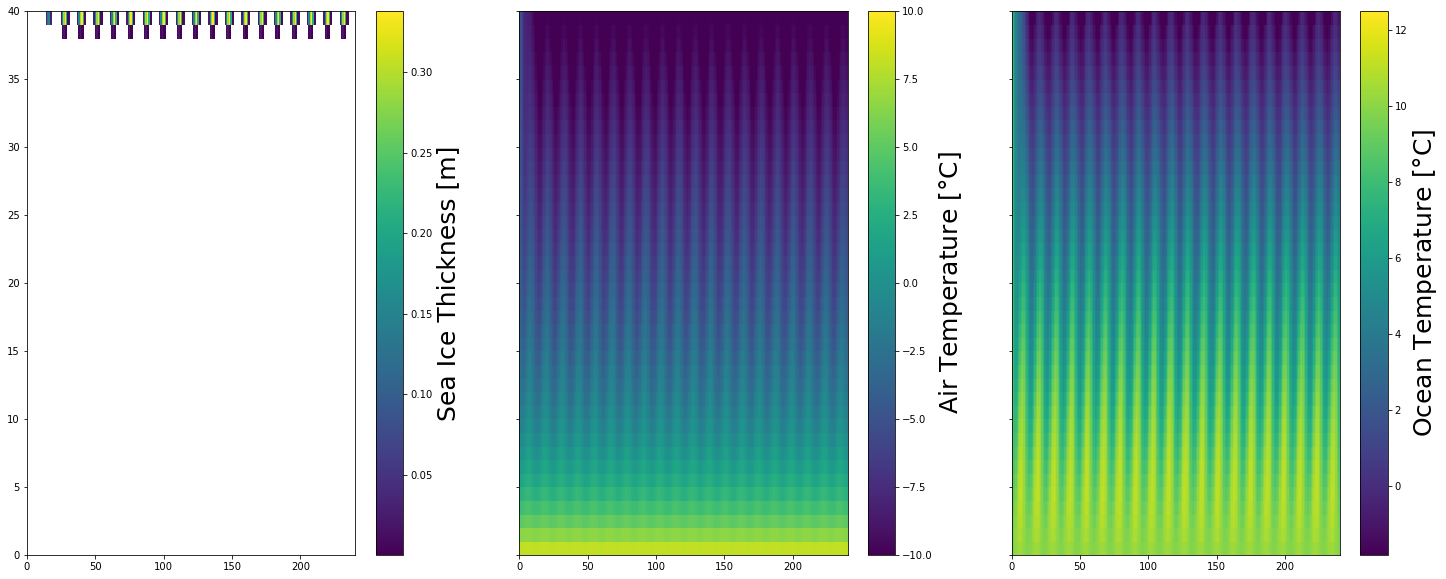

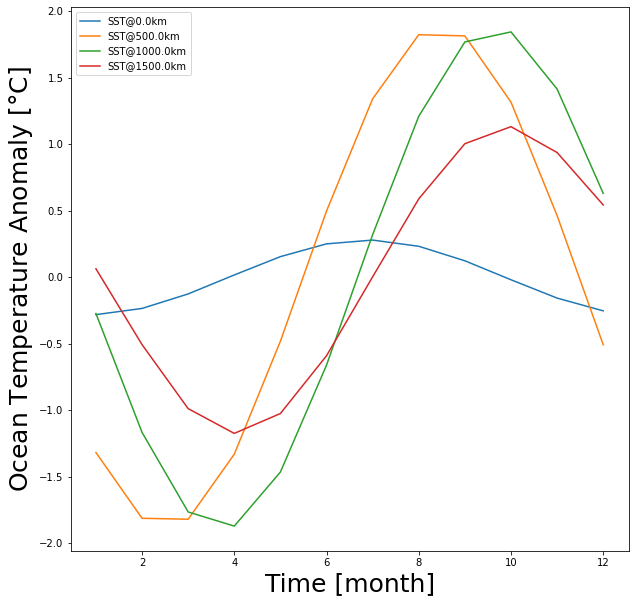

In [369]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-20,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+2.5)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
for j in range(0,C['nx'],10):
    ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,j]-np.nanmean(sst_out[-360*24*3600//C['avep']:,j]),label='SST@'+str(C['xx']*j/1E3)+'km')

ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## EXAMPLE - CONTROL CLIMATE WITH VARIABLE BOUNDARY CONDITIONS

As an example, we run the model for 20 years with constant shortwave forcing (12 month sine) and daily restoring to a variable inflow temperatures which balance the net cooling by longwave radiation.

In [405]:
# set total run time to 10 years
tmax = 20*360*24*3600 #
C['dT'] = 2
#
T_boundary=C['T0']-C['dT']*np.cos(2*np.pi*(np.arange(0,C['tmax'],C['dt']))/(5*360*24*3600))
#
#plt.plot(T_boundary)
%time tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f,T_boundary=T_boundary, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Year  1.0 279.5521371516016 274.25957583809765
Year  2.0 281.75131578369377 275.20754424415685
Year  3.0 282.57109312140426 276.7779530285407
Year  4.0 280.87949477542634 276.32727490173204
Year  5.0 279.01253622603883 274.4746419083309
Year  6.0 279.55211591607673 273.78153306545266
Year  7.0 281.7513157836937 275.20754154517596
Year  8.0 282.57109312140426 276.77795291419324
Year  9.0 280.87949477542634 276.32727490173204
Year  10.0 279.01253622603883 274.47464190833085
Year  11.0 279.55211591607673 273.78153306545266
Year  12.0 281.7513157836937 275.20754154517596
Year  13.0 282.57109312140426 276.77795291419324
Year  14.0 280.87949477542634 276.32727490173204
Year  15.0 279.01253622603883 274.4746419083309
Year  16.0 279.55211591607673 273.78153306545266
Year  17.0 281.75131578369366 275.20754154517596
Year  18.0 282.57109312140426 276.77795291419324
Year  19.0 280.8794947754263 276.32727490173204
Year  20.0 279.01253622603883 274.4746419083309
CPU times: user 32 s, sys: 192 ms, to

Text(0.5, 0, 'Time [month]')

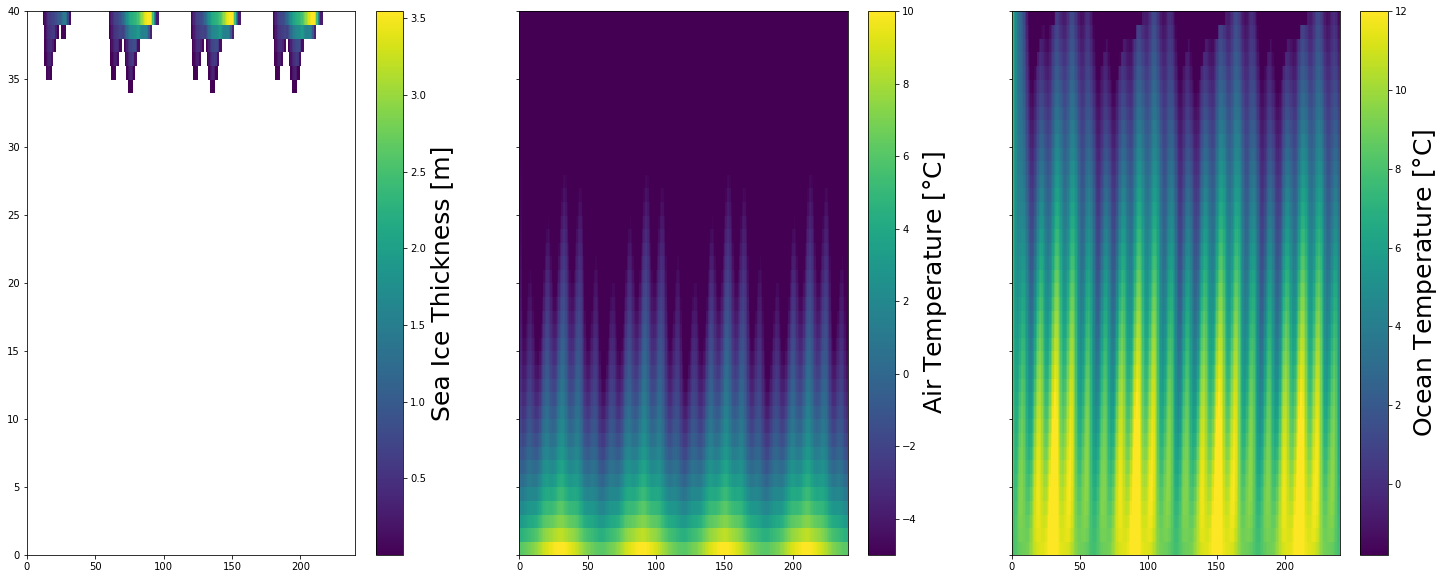

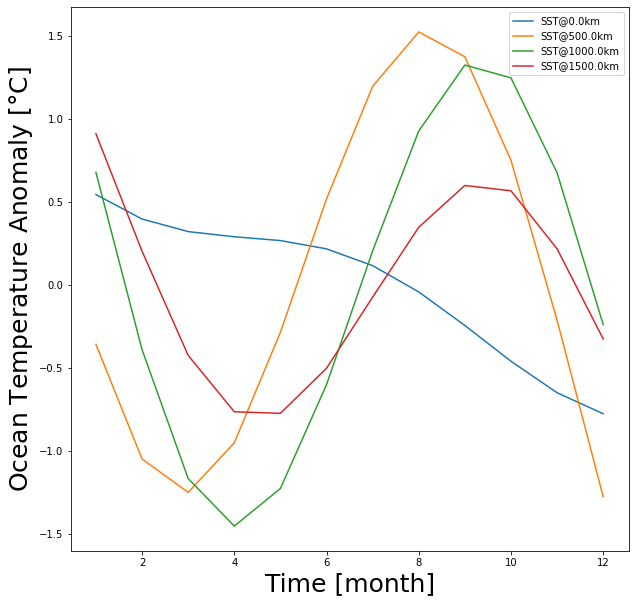

In [406]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-15,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+2)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
for j in range(0,C['nx'],10):
    ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,j]-np.nanmean(sst_out[-360*24*3600//C['avep']:,j]),label='SST@'+str(C['xx']*j/1E3)+'km')

ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## EXERCISE 1 - SLAB OCEAN

Show that by diagnosing the fluxes from a fully coupled simulation you can replicate the same control climate.

In [408]:
# 
#H=50
#va=5
#args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
# first run a control case for 10 years without any time-variable forcing
tmax=20*360*24*3600
C['tmax']=tmax
C['dT'] = 0.0
#C    = cutils.set_model_constants(**args)
forcing = None
#
#T_boundary=C['T0']-C['dT']*np.cos(2*np.pi*(np.arange(0,C['tmax'],C['dt']))/(360*24*3600))
#
tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)


Year  1.0 280.75376757923914 275.4695070223105
Year  2.0 280.75376478667897 275.31504502656344
Year  3.0 280.75376478667897 275.31504460597887
Year  4.0 280.75376478667897 275.31504460597887
Year  5.0 280.75376478667897 275.31504460597887
Year  6.0 280.75376478667897 275.31504460597887
Year  7.0 280.75376478667897 275.31504460597887
Year  8.0 280.75376478667897 275.31504460597887
Year  9.0 280.75376478667897 275.31504460597887
Year  10.0 280.75376478667897 275.31504460597887
Year  11.0 280.75376478667897 275.31504460597887
Year  12.0 280.75376478667897 275.31504460597887
Year  13.0 280.75376478667897 275.31504460597887
Year  14.0 280.75376478667897 275.31504460597887
Year  15.0 280.75376478667897 275.31504460597887
Year  16.0 280.75376478667897 275.31504460597887
Year  17.0 280.75376478667897 275.3150446059788
Year  18.0 280.75376478667897 275.31504460597887
Year  19.0 280.75376478667897 275.31504460597887
Year  20.0 280.75376478667897 275.31504460597887


In [409]:
# then run a case without ocean advection, but input the DA tendencies using the last 10 years of the previous case 
atm_DA_tendencies2 = atm_DA_tendencies[-int(360*24*3600//C['dt']):]
ocn_DA_tendencies2 = ocn_DA_tendencies[-int(360*24*3600//C['dt']):]
#
tmax=20*360*24*3600
C['tmax']=tmax
C['vo']=0.0
tas_out_slab, sst_out_slab, hice_out_slab, sflx_out_slab, sflx_f_out_slab, nt1, nt = cutils.CoupledChannel(C,forcing, dt_f=dt_f,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2,atm_DA_tendencies=atm_DA_tendencies2)
#

Year  1.0 282.5746987156753 281.29801485299
Year  2.0 282.1209998076932 279.871549875343
Year  3.0 281.78079009959094 278.7899088711951
Year  4.0 281.52548670649423 277.96776706670084
Year  5.0 281.33378999870354 277.34172958853986
Year  6.0 281.18979116008114 276.8643602415344
Year  7.0 281.08158718934965 276.49997052074946
Year  8.0 281.00026061396795 276.2215979048418
Year  9.0 280.9391240913149 276.00880694553763
Year  10.0 280.8931589783405 275.8460710880285
Year  11.0 280.858596844471 275.7215712335272
Year  12.0 280.83260684263604 275.62629746204345
Year  13.0 280.8130617696377 275.55337373510565
Year  14.0 280.7983627878545 275.4975480601738
Year  15.0 280.78730797304803 275.45480630003846
Year  16.0 280.7789936591015 275.42207889118913
Year  17.0 280.77274035663766 275.3970176787434
Year  18.0 280.76803710170077 275.377825845898
Year  19.0 280.7644996365647 275.3631281538883
Year  20.0 280.7618389773694 275.3518718487258


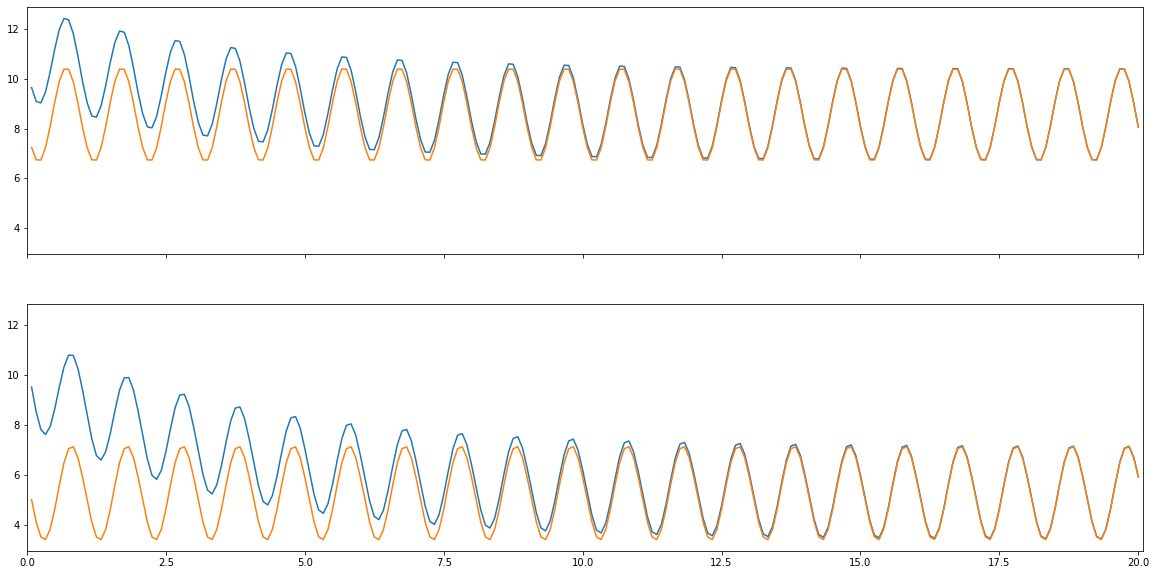

In [410]:
fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True,figsize=(20,10))
diag_points=[10,20]
timeaxis=np.arange(1/12,20,1/12)
for a,ax in enumerate(axes.flatten()):
    j=diag_points[a]
    ax.plot(timeaxis,sst_out_slab[:,j]-273.15)
    ax.plot(timeaxis,np.tile(sst_out[-360*24*3600//C['avep']:,j],20)-273.15)
    ax.set_xlim(0,20+1/12)
#

Text(0.5, 0, 'Time [month]')

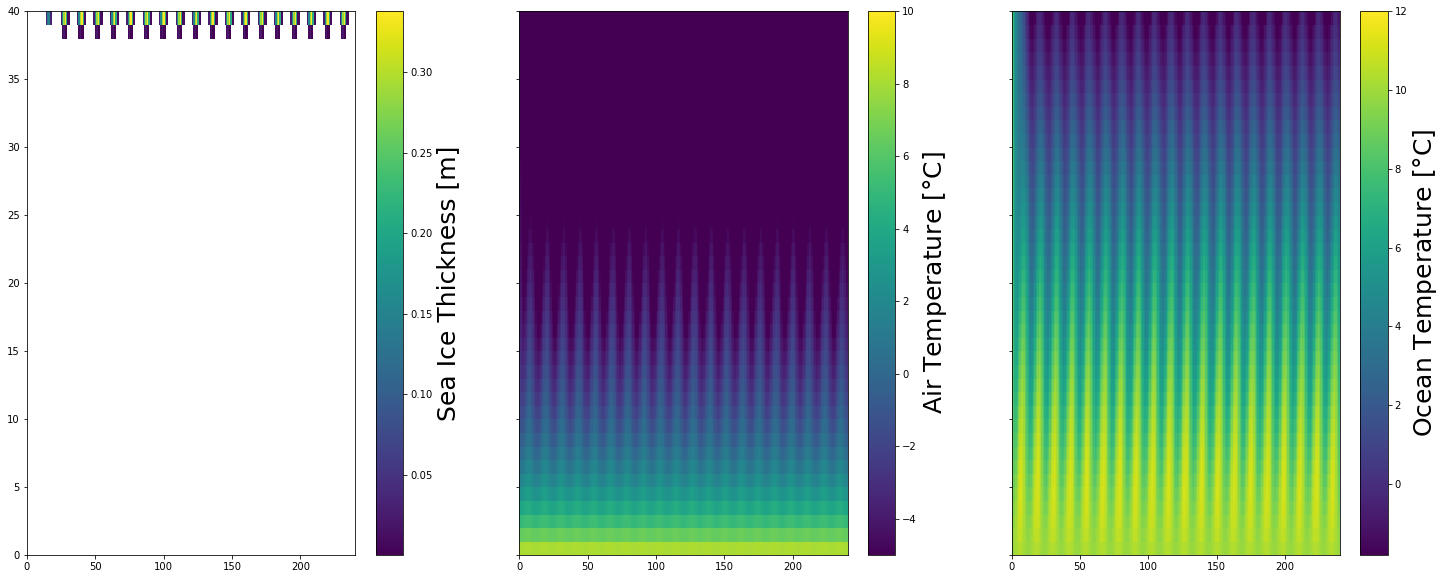

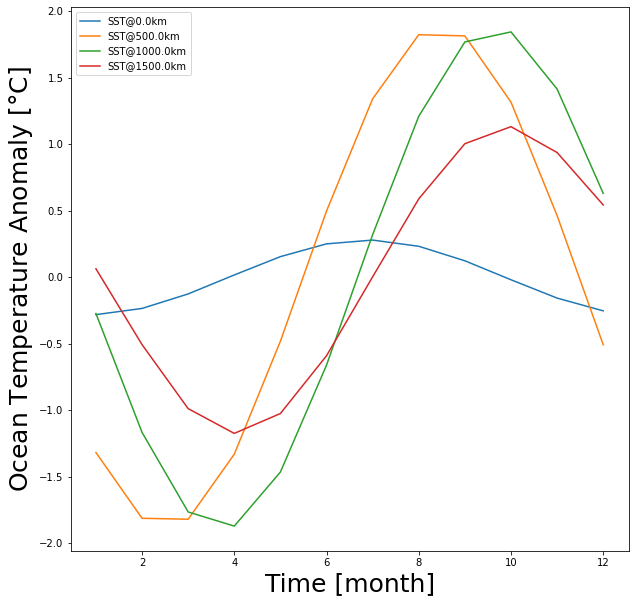

In [411]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-15,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+2)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
for j in range(0,C['nx'],10):
    ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,j]-np.nanmean(sst_out[-360*24*3600//C['avep']:,j]),label='SST@'+str(C['xx']*j/1E3)+'km')

ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## Exercise 2 - Perturbation Study



In [ ]:
# 
tas_out0, sst_out0, hice_out0, sflx_out0, sflx_f_out0, nt1_0, nt0 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern)

## Realistic Forcing

In [ ]:
#forcings
#nao=np.loadtxt('norm.nao.monthly.b5001.current.ascii.table')[:-1,-1]; dt_f=30*24*3600 #66 years of monthly NAO
nao0 = np.loadtxt('../data/raw/norm.daily.nao.index.b500101.current.ascii')[:,-1]; dt_f=24*3600 #66 yeas of daily NAO
#
nao_surrogate    = Surrogates(np.tile(nao0[:50*360,np.newaxis],22).T)
nao_s = nao_surrogate.refined_AAFT_surrogates(np.tile(nao0[:50*360,np.newaxis],22).T,10).flatten().squeeze()
nao_s = -2*(0.5-(nao_s - np.min(nao_s,0))/np.max((nao_s - np.min(nao_s,0)),0))
#
nao_white=1-2*np.random.rand(len(nao_s))
#
tmax = (len(nao_s)-1*360.)*dt_f
#
forcing = nao_s #None #100*nao
forcing_str = 'synthetic_nao_random_spatial'



In [ ]:
plt.figure(figsize=(20,5))
#
plt.plot(nao_white)
plt.plot(nao_s)
#
plt.figure()
f0,p0 = signal.welch(-2*(0.5-(nao0 - np.min(nao0,0))/np.max((nao0 - np.min(nao0,0)),0)),fs=1,nperseg=20*360)
f1,p1 = signal.welch(nao_s,fs=1,nperseg=20*360)
f2,p2 = signal.welch(nao_white,fs=1,nperseg=20*360)
plt.loglog(f0,p0)
plt.loglog(f1,p1)
plt.loglog(f2,p2)
plt.axvline(x=1/30,lw=2,ls='--',color='gray')

In [7]:
# RUN THE MODEL
data={}
for nf_str,nao in enumerate([nao_s,nao_white]):
    if nf_str==0:
        forcing_str = 'synthetic_nao_random_spatial'
    elif nf_str==1:
        forcing_str = 'white_noise_nao_random_spatial'
    #
    for H in [50]: #,100,200]:
        for va in [5]: #,10,15]:
            #print(H,va)
            #if os.path.exists('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz'):
            #    print('case exists - loading...')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz')
            #    data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz')
            #    print('done!')
            #else:
                tmax = 50*360*24*3600
                args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
                # first run a control case for 10 years without any forcing
                C    = cutils.set_model_constants(**args)
                forcing = None
                tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)
                atm_DA_tendencies2 = atm_DA_tendencies[-360*24*3600//C['dt']:]
                ocn_DA_tendencies2 = ocn_DA_tendencies[-360*24*3600//C['dt']:]
                # then run a fully coupled case with varying forcing
                forcing = nao
                tmax    = (len(nao)-1*360)*dt_f
                args['tmax'] = tmax
                C = cutils.set_model_constants(**args)
                #
                tas_out0, sst_out0, hice_out0, sflx_out0, sflx_f_out0, nt1_0, nt0 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern)
                # then run a slab ocean case (i.e. ocean advection and diffusion tendencies from the control case)
                tas_out1, sst_out1, hice_out1, sflx_out1, sflx_f_out1, nt1_1, nt1 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2)
                # then run a slab_atm (i.e. atm advection and diffusion tendencies from the control case)
                tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt1_2, nt2 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,atm_DA_tendencies=atm_DA_tendencies2)
                #Save the data
                #
                print('saving the data...')
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz',tas_out=tas_out0, sst_out=sst_out0, hice_out=hice_out0, sflx_out=sflx_out0, sflx_f_out=sflx_f_out0,nt1=nt1_0,nt=nt0,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz',tas_out=tas_out1, sst_out=sst_out1, hice_out=hice_out1, sflx_out=sflx_out1, sflx_f_out=sflx_f_out1,nt1=nt1_1,nt=nt1,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                np.savez('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz',tas_out=tas_out2, sst_out=sst_out2, hice_out=hice_out2, sflx_out=sflx_out2, sflx_f_out=sflx_f_out2,nt1=nt1_2,nt=nt2,nx=nx,xx=xx,tmax=tmax,dt=dt,avep=avep)
                #
                #load the same data
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_fully_coupled.npz')
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_ocean.npz')
                data[str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm'] = np.load('ChannelModel_output_H'+str(H)+'_va'+str(va)+'_'+forcing_str+'_slab_atm.npz')
        #

293.15 [160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143
 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 125
 124 123 122 121] 100000.0 50000.0
0.9654210260279585
293.15 294.11542102602795
Year  1.0 279.7300597948741 278.87574551433653
Year  2.0 275.55166661195165 272.8628869571969
Year  3.0 274.7019271558007 271.6107638494162
Year  4.0 274.5276917650988 271.35936239121025
Year  5.0 274.49190601084376 271.35000149386104
Year  6.0 274.48455356028126 271.3500001899152
Year  7.0 274.4830428385747 271.35000080947884
Year  8.0 274.4827324233054 271.35000096621076
Year  9.0 274.48266864059445 271.35000056873713
Year  10.0 274.48265553480974 271.35000129237085
Year  11.0 274.4826528418891 271.35000015829127
Year  12.0 274.48265228856206 271.3500007127731
Year  13.0 274.4826521748649 271.35000053263286
Year  14.0 274.4826521515046 271.35000049562024
Year  15.0 274.482652146702 271.3500004880129
Year  16.0 274.4826521457154 271.3500004864484
Year  17.